In [30]:
import os
import itertools

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from bs4 import BeautifulSoup

In [2]:
experiments = os.listdir('../data')

In [47]:
def extract_tripinfo(tripinfo, path):
    vid = tripinfo['id']
    vtype = tripinfo['vType']
    depart_time = float(tripinfo['depart'])
    depart_lane = tripinfo['departLane']
    depart_delay = float(tripinfo['departDelay'])
    arrival_time = float(tripinfo['arrival'])
    arrival_lane = tripinfo['arrivalLane']
    duration = float(tripinfo['duration'])
    route_length = float(tripinfo['routeLength'])
    waiting_time = float(tripinfo['waitingTime'])
    waiting_count = int(tripinfo['waitingCount'])
    time_loss = float(tripinfo['timeLoss'])
    speed_factor = float(tripinfo['speedFactor'])
    
    emissions = tripinfo.find('emissions')
    co_abs = float(emissions['CO_abs'])
    co2_abs = float(emissions['CO2_abs'])
    hc_abs = float(emissions['HC_abs'])
    pmx_abs = float(emissions['PMx_abs'])
    nox_abs = float(emissions['NOx_abs'])
    fuel_abs = float(emissions['fuel_abs'])
    
    return path, vid, vtype, depart_time, depart_lane, depart_delay, arrival_time, arrival_lane, duration, route_length, waiting_time, waiting_count, time_loss, speed_factor, co_abs, co2_abs, hc_abs, pmx_abs, nox_abs, fuel_abs


def extract_personinfo(personinfo, path):
    vid = personinfo['id']
    vtype = personinfo['type']
    
    walk = personinfo.find('walk')
    depart_time = float(walk['depart'])
    depart_lane = None
    depart_delay = None
    arrival_time = float(walk['arrival'])
    arrival_lane = None
    duration = float(walk['duration'])
    route_length = float(walk['routeLength'])
    waiting_time = None
    waiting_count = None
    time_loss = float(walk['timeLoss'])
    speed_factor = None
    
    co_abs = 0
    co2_abs = 0
    hc_abs = 0
    pmx_abs = 0
    nox_abs = 0
    fuel_abs = 0
    
    return path, vid, vtype, depart_time, depart_lane, depart_delay, arrival_time, arrival_lane, duration, route_length, waiting_time, waiting_count, time_loss, speed_factor, co_abs, co2_abs, hc_abs, pmx_abs, nox_abs, fuel_abs


def extract_tripinfos(path):
    def curry_extract_tripinfo(tripinfo):
        return extract_tripinfo(tripinfo, path)
    
    def curry_extract_personinfo(personinfo):
        return extract_personinfo(personinfo, path)
    
    with open('../data/{}/tripinfo.xml'.format(path)) as file:
        parsed = BeautifulSoup(file, 'xml')
        
        tripinfos = parsed.find_all('tripinfo')
        personinfos = parsed.find_all('personinfo')
        
        return itertools.chain(map(curry_extract_tripinfo, tripinfos), map(curry_extract_personinfo, personinfos))
    
trips = pd.DataFrame(tqdm(itertools.chain.from_iterable(map(extract_tripinfos, experiments))), columns=[
    'path', 'vid', 'vtype', 'depart_time', 'depart_lane', 'depart_delay', 
    'arrival_time', 'arrival_lane', 'duration', 'route_length', 
    'waiting_time', 'waiting_count', 'time_loss', 'speed_factor',
    'co_abs', 'co2_abs', 'hc_abs', 'pmx_abs', 'nox_abs', 'fuel_abs'
])

In [48]:
trips.head()

,path,vid,vtype,depart_time,depart_lane,depart_delay,arrival_time,arrival_lane,duration,route_length,waiting_time,waiting_count,time_loss,speed_factor,co_abs,co2_abs,hc_abs,pmx_abs,nox_abs,fuel_abs
0,aarhus_prediction_30_control_20_prob,bike_straight_b.0,DEFAULT_BIKETYPE,10.45,24095610_0,0.0,81.45,502199947#0_0,71.00,376.96,0.05,1.0,3.14,0.95,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,aarhus_prediction_30_control_20_prob,a2_right_v.2,DEFAULT_VEHTYPE,17.05,gneE14_2,0.0,82.95,502199947#0_1,65.90,981.34,0.00,0.0,2.15,1.12,1486.694004,164805.399487,10.472182,2.616911,63.465550,70.842521
2,aarhus_prediction_30_control_20_prob,a2_right_v.1,DEFAULT_VEHTYPE,12.50,gneE14_2,0.0,88.00,502199947#0_1,75.50,981.34,0.00,0.0,2.64,0.98,1714.763883,173069.703458,11.812575,2.631048,66.820066,74.395222
3,aarhus_prediction_30_control_20_prob,a2_straight_v.0,DEFAULT_VEHTYPE,0.15,gneE14_1,0.0,95.10,gneE6_2,94.95,1540.73,0.00,0.0,2.64,1.20,2024.045747,250002.986706,14.829118,4.012623,95.393929,107.465030
4,aarhus_prediction_30_control_20_prob,a2_right_v.0,DEFAULT_VEHTYPE,12.05,gneE14_1,0.0,97.60,502199947#0_1,85.55,981.34,0.00,0.0,1.52,0.85,1767.380100,161011.091985,11.748318,2.246608,61.446416,69.212143


In [49]:
aarhus = trips[trips['path'].str.startswith('aarhus')]

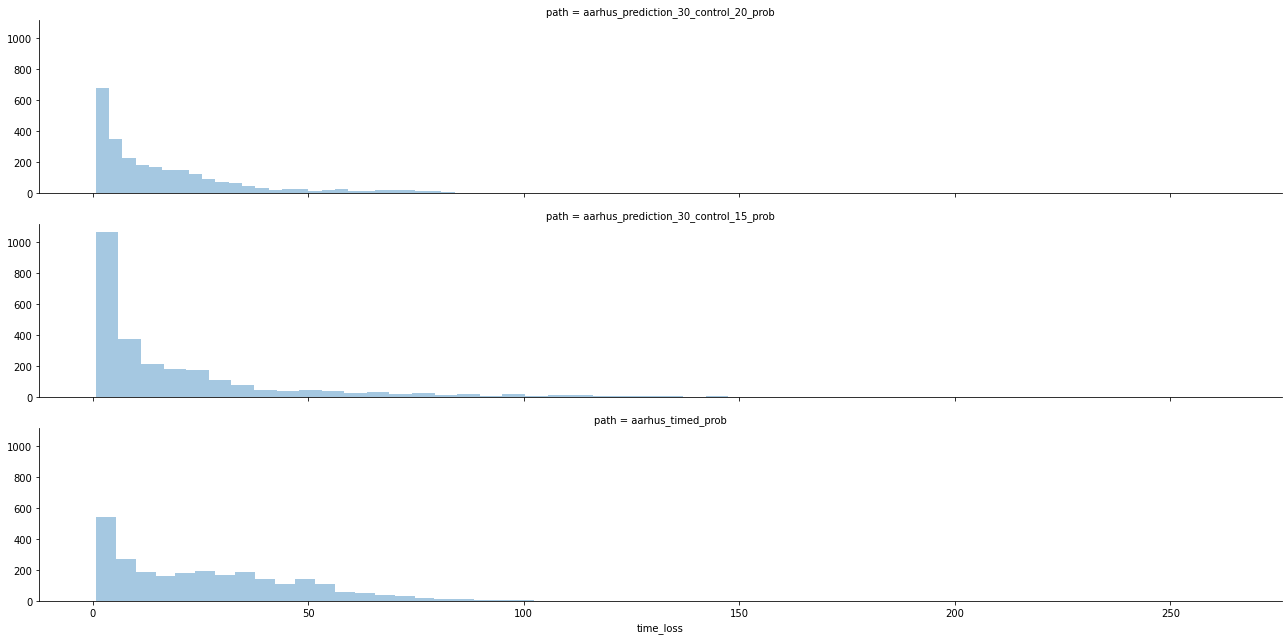

In [50]:
g = sns.FacetGrid(aarhus, row='path',
                  height=3, aspect=6)
g.map(sns.distplot, 'time_loss', kde=False);

In [62]:
aarhus_avg = aarhus[['path', 'time_loss']].groupby('path')['time_loss'].mean()
aarhus_avg

path
aarhus_prediction_30_control_15_prob    21.193403
aarhus_prediction_30_control_20_prob    17.674703
aarhus_timed_prob                       26.329476
Name: time_loss, dtype: float64

In [63]:
(aarhus_avg.max() - aarhus_avg) / aarhus_avg.max()

path
aarhus_prediction_30_control_15_prob    0.195069
aarhus_prediction_30_control_20_prob    0.328710
aarhus_timed_prob                       0.000000
Name: time_loss, dtype: float64

In [58]:
simple = trips[trips['path'].str.startswith('simple')]

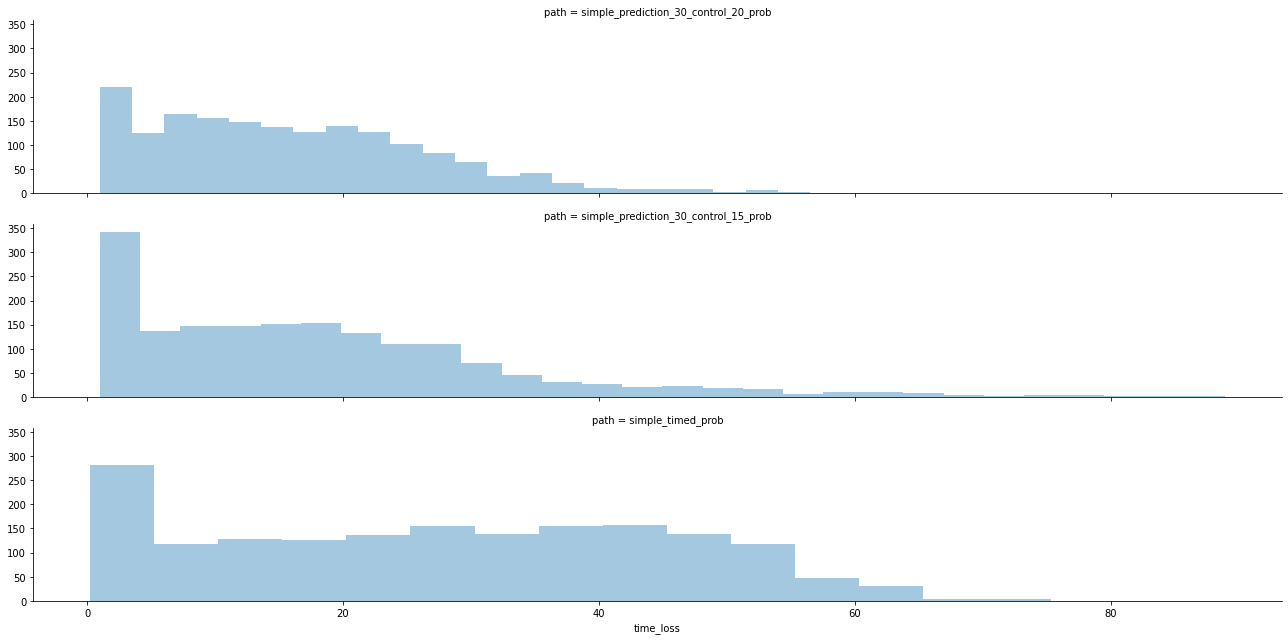

In [59]:
g = sns.FacetGrid(simple, row='path',
                  height=3, aspect=6)
g.map(sns.distplot, 'time_loss', kde=False);

In [60]:
simple_avg = simple[['path', 'time_loss']].groupby('path')['time_loss'].mean()
simple_avg

path
simple_prediction_30_control_15_prob    18.399473
simple_prediction_30_control_20_prob    16.091013
simple_timed_prob                       27.444374
Name: time_loss, dtype: float64

In [61]:
(simple_avg.max() - simple_avg) / simple_avg.max()

path
simple_prediction_30_control_15_prob    0.329572
simple_prediction_30_control_20_prob    0.413686
simple_timed_prob                       0.000000
Name: time_loss, dtype: float64

In [66]:
super_simple = trips[trips['path'].str.startswith('super_simple')]

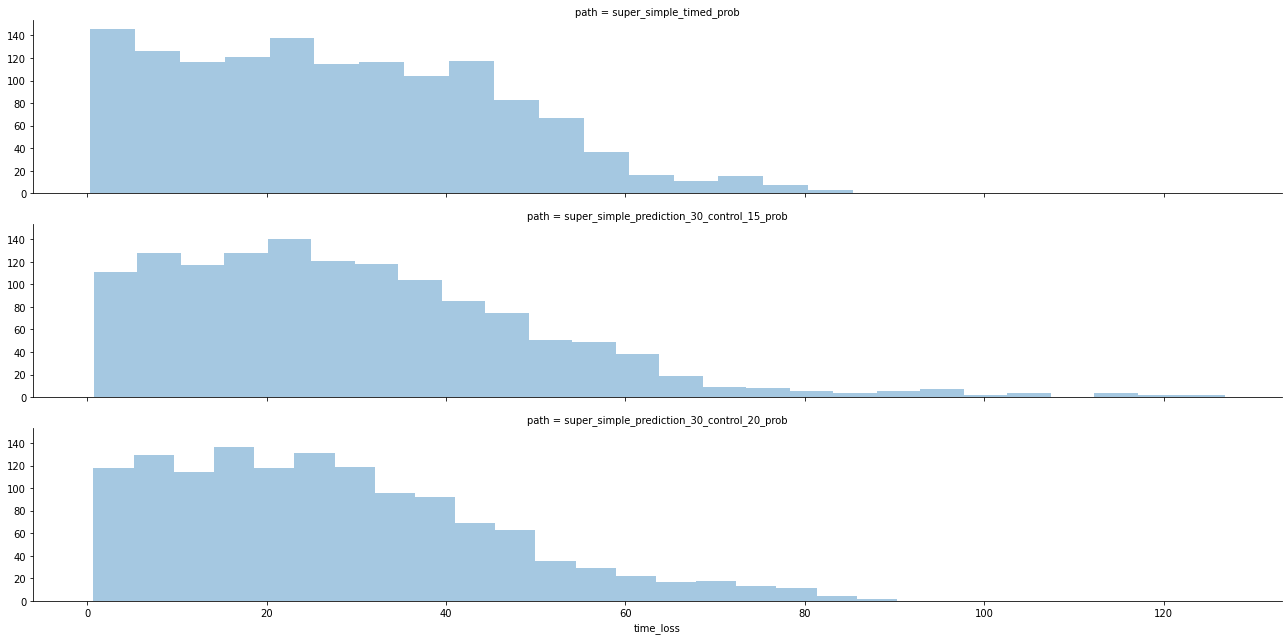

In [67]:
g = sns.FacetGrid(super_simple, row='path',
                  height=3, aspect=6)
g.map(sns.distplot, 'time_loss', kde=False);

In [68]:
super_simple_avg = super_simple[['path', 'time_loss']].groupby('path')['time_loss'].mean()
super_simple_avg

path
super_simple_prediction_30_control_15_prob    29.840621
super_simple_prediction_30_control_20_prob    27.338031
super_simple_timed_prob                       27.917063
Name: time_loss, dtype: float64

In [69]:
(super_simple_avg.max() - super_simple_avg) / super_simple_avg.max()

path
super_simple_prediction_30_control_15_prob    0.000000
super_simple_prediction_30_control_20_prob    0.083865
super_simple_timed_prob                       0.064461
Name: time_loss, dtype: float64

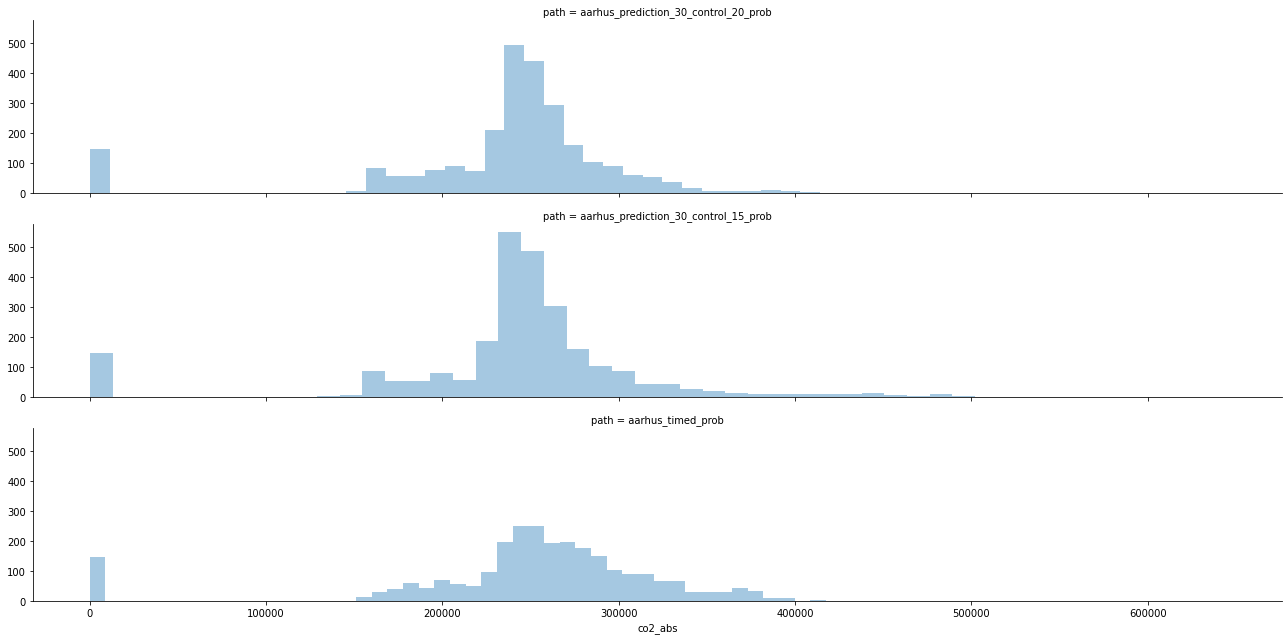

In [70]:
g = sns.FacetGrid(aarhus, row='path',
                  height=3, aspect=6)
g.map(sns.distplot, 'co2_abs', kde=False);

In [73]:
aarhus_co2_avg = aarhus[['path', 'co2_abs']].groupby('path')['co2_abs'].mean()
aarhus_co2_avg

path
aarhus_prediction_30_control_15_prob    242520.136335
aarhus_prediction_30_control_20_prob    235739.859503
aarhus_timed_prob                       250976.665494
Name: co2_abs, dtype: float64

In [74]:
(aarhus_co2_avg.max() - aarhus_co2_avg) / aarhus_co2_avg.max()

path
aarhus_prediction_30_control_15_prob    0.033694
aarhus_prediction_30_control_20_prob    0.060710
aarhus_timed_prob                       0.000000
Name: co2_abs, dtype: float64